In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from matplotlib.colors import LogNorm
import tarfile
import math

from discretize import TreeMesh
from discretize.utils import mkvc, active_from_xyz, refine_tree_xyz

from SimPEG.utils import model_builder
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static import utils as dc_utils
from SimPEG.electromagnetics.static import induced_polarization as ip
from SimPEG.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    apparent_resistivity_from_voltage,
    plot_pseudosection,
)
from SimPEG.utils.io_utils.io_utils_electromagnetics import read_dcip2d_ubc

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

from matplotlib.patches import Circle

mpl.rcParams.update({"font.size": 10})
#plt.rcParams["font.family"] = "Arial"

In [2]:
x_topo, y_topo = np.meshgrid(
    np.linspace(-100, 100, 201), np.linspace(-100, 100, 201)
)
#z_topo = 40.0 * np.sin(2 * np.pi * x_topo / 800) - 40.0
z_topo = 0 * x_topo
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
topo_xyz = np.c_[x_topo, y_topo, z_topo]

# Create 2D topography. Since our 3D topography only changes in the x direction,
# it is easy to define the 2D topography projected along the survey line. For
# arbitrary topography and for an arbitrary survey orientation, the user must
# define the 2D topography along the survey line.
topo_2d = np.unique(topo_xyz[:, [0, 2]], axis=0)

In [3]:
# Generate source list for IP survey line
ip_data_type = "apparent_chargeability"
survey_type = "dipole-dipole"
dimension_type = "2D"
end_locations = np.r_[-20.0, 20.0]
station_separation = 1.0
num_rx_per_src = 40

source_list = generate_dcip_sources_line(
    survey_type,
    ip_data_type,
    dimension_type,
    end_locations,
    topo_xyz,
    num_rx_per_src,
    station_separation,
)

# Define survey
ip_survey = ip.survey.Survey(source_list, survey_type=survey_type)

C:\Users\dwill\Documents\Projects\SOLA\simpeg\simpeg\electromagnetics\static\resistivity\survey.py:32: FutureWarning: Argument 'survey_type' is ignored and will be removed in future versions of SimPEG. Types of sources and their corresponding receivers are obtained from their respective classes, without the need to specify the survey type.
  warnings.warn(


In [4]:
dh = 0.1  # base cell width
dom_width_x = 100.0  # domain width x
dom_width_z = 30.0  # domain width z
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh
hx = [(dh, nbcx)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hz], x0="CN")

# Mesh refinement based on topography
#mesh.refine_surface(topo_xyz[:, [0, 2]], finalize=False)

# Mesh refinement near transmitters and receivers. First we need to obtain the
# set of unique electrode locations.
#electrode_locations = np.c_[
#    ip_survey.locations_a,
#    ip_survey.locations_b,
#    ip_survey.locations_m,
#    ip_survey.locations_n,
#]

#unique_locations = np.unique(
#    np.reshape(electrode_locations, (4 * ip_survey.nD, 2)), axis=0
#)

#mesh = refine_tree_xyz(
#    mesh, unique_locations, octree_levels=[4, 4], method="radial", finalize=False
#)

# Refine core mesh region
mesh.refine_box([-30, -12], [30, 0.0], -1, finalize=False)

mesh.finalize()

C:\Users\dwill\AppData\Local\Temp\ipykernel_14696\610347756.py:10: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  mesh = TreeMesh([hx, hz], x0="CN")


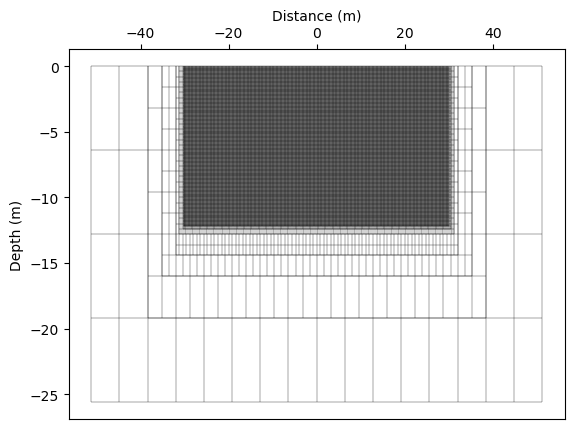

In [5]:
ax = mesh.plot_grid(linewidth=0.25, color='black')
plt.grid(False)
#ax.set_xlim([-20,20])
ax.set_xlabel('Distance (m)', loc='center')
ax.set_ylabel('Depth (m)')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.savefig('toy_grid_model.png', dpi=300)

In [6]:
# Define conductivity model in S/m 
air_conductivity = 1e-8
background_conductivity = 1e-2

# Find active cells in forward modeling (cell below surface)
ind_active = active_from_xyz(mesh, topo_xyz[:, [0, 2]])

# Define mapping from model to active cells
nC = int(ind_active.sum())
conductivity_map = maps.InjectActiveCells(mesh, ind_active, air_conductivity)

# Define model
conductivity_model = background_conductivity * np.ones(nC)


In [ ]:
# Drape over discrete topography
#ip_survey.drape_electrodes_on_topography(mesh, ind_active, option="top")

(81, 405)


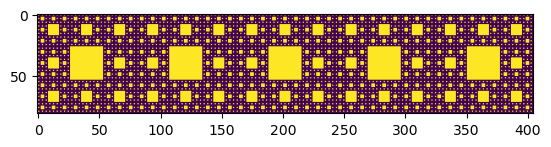

In [7]:
##
# Sierpinsky carpet
# importing necessary modules 
import numpy as np 
#from PIL import Image 
  
# total number of times the process will be repeated 
total = 4
  
# size of the image 
size = 3**total 
  
# creating an image 
square = np.empty([size, size]) 
 
# filling it black 
square.fill(0) 
  
for i in range(0, total + 1): 
    stepdown = 3**(total - i) 
    for x in range(0, 3**i):           
        # checking for the centremost square 
        if x % 3 == 1: 
            for y in range(0, 3**i): 
                if y % 3 == 1:                      
                    # changing its color 
                    square[y * stepdown:(y + 1)*stepdown, x * stepdown:(x + 1)*stepdown] = 0.2 

square2 = np.c_[square, square, square, square, square]
print(square2.shape)
fig, ax = plt.subplots()
ax.imshow(square2)
plt.show()

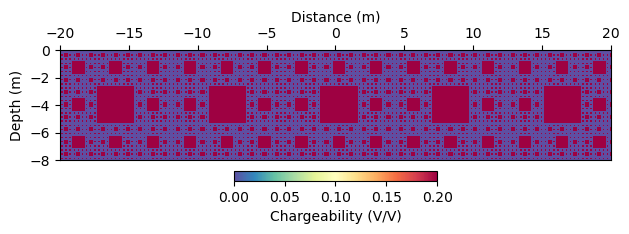

In [11]:
# Define chargeability model as intrinsic chargeability (V/V).
air_chargeability = 0.0
background_chargeability = 1e-6
sphere_chargeability = 0.2

# Find active cells in forward modeling (cells below surface)
ind_active = active_from_xyz(mesh, topo_xyz[:, [0, 2]])

# Define mapping from model to active cells
nC = int(ind_active.sum())
chargeability_map = maps.InjectActiveCells(mesh, ind_active, air_chargeability)

# Define chargeability model
chargeability_model = background_chargeability * np.ones(nC)

# Block 1
block1_coords = [np.r_[-20.0, -2.0], np.r_[-15, -1.0]]
ind_chargeable = model_builder.get_indices_block(
    np.r_[-20.0, -2.0], np.r_[-15, -1.0], mesh.gridCC
)
chargeability_model[ind_chargeable] = sphere_chargeability

# Block 2
block2_coords = [np.r_[-10.0, -3.0], np.r_[-5, -1.0]]
ind_chargeable = model_builder.get_indices_block(
    np.r_[-10.0, -3.0], np.r_[-5, -1.0], mesh.gridCC
)
chargeability_model[ind_chargeable] = sphere_chargeability

# Block 3
block3_coords = [np.r_[0.0, -4.0], np.r_[5, -2.0]]
ind_chargeable = model_builder.get_indices_block(
    np.r_[0.0, -4.0], np.r_[5, -2.0], mesh.gridCC
)
chargeability_model[ind_chargeable] = sphere_chargeability

# Block 4
block4_coords = [np.r_[10.0, -5.0], np.r_[15, -2.0]]
ind_chargeable = model_builder.get_indices_block(
    np.r_[10.0, -5.0], np.r_[15, -2.0], mesh.gridCC
)
chargeability_model[ind_chargeable] = sphere_chargeability

# Block 5
block5_coords = [np.r_[20.0, -7.0], np.r_[25, -4.0]]
ind_chargeable = model_builder.get_indices_block(
    np.r_[20.0, -7.0], np.r_[25, -4.0], mesh.gridCC
)
chargeability_model[ind_chargeable] = sphere_chargeability

##
# 
sq_nz, sq_nx = square2.shape
xmin = -20; xmax = 20
zmin = -8; zmax = 0
chargeability_model[:] = 0
cell_centers = mesh.cell_centers
nC = mesh.nC
nC = mesh.nC
for i in range(nC):
    xc = cell_centers[i,0]
    zc = cell_centers[i,1]
    if xc > xmin and xc < xmax:
        if zc > zmin and zc < zmax:
            ix = int((xc-xmin)/dh)
            iz = int((zc-zmin)/dh)
            if (ix < sq_nx) and (iz < sq_nz):
                chargeability_model[i] = square2[iz,ix]
                
# Plot Chargeability Model
fig, ax = plt.subplots()
charge_true = chargeability_map*chargeability_model
charge_true[~ind_active] = np.nan
out = mesh.plot_image(charge_true, normal="Y",
                      ax=ax, clim = (0,0.2),
                      grid=False, pcolor_opts={"cmap": "Spectral_r"})
cb = plt.colorbar(out[0], fraction=0.025, 
                  orientation='horizontal',                   
                  ax=ax, pad=0.025)
cb.set_label("Chargeability (V/V)")

ax.set_xlim(-20, 20)
ax.set_ylim(-8, 0)
ax.set_yticks([0, -2, -4, -6, -8])
ax.set_aspect(1.0)
ax.set_xlabel('Distance (m)', loc = "center")
ax.set_ylabel('Depth (m)')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.tight_layout()

plt.savefig('toy_model.png', dpi=300, bbox_inches='tight')

plt.show()

In [9]:
air_chargeability = 0.0
chargeability_map = maps.InjectActiveCells(mesh, ind_active, air_chargeability)

ip_simulation = ip.Simulation2DNodal(mesh,
    survey=ip_survey,
    etaMap=chargeability_map,
    sigma=conductivity_map * conductivity_model,
    solver=Solver,
    storeJ=True,
) 


In [10]:
# Run forward simulation and predicted IP data. The data are the voltage (V)
dpred_ip = ip_simulation.dpred(chargeability_model)

C:\Users\dwill\.conda\envs\simpeg-dev\Lib\site-packages\pymatsolver\solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


In [ ]:
# Plot apparent chargeability
fig, ax1 = plt.subplots(1, 1, figsize=(8,6))
ax = dc_utils.plot_pseudosection(
    ip_survey,
    dpred_ip,
    data_type='potential',
    plot_type="contourf",
    ax=ax1,
    data_location=True,
    cbar_label="Voltage (V)",
    create_colorbar=False,
)

ax[0].set_aspect(0.5)
fig.colorbar(ax[1], orientation='horizontal', shrink=0.5, pad=0.1, label='Voltage (V)')
plt.tight_layout()

plt.savefig('toy_data.png', dpi=300, bbox_inches='tight')
plt.show()

# Setup data for inversions

Setup inversions

In [12]:
##
# Observations
nobs = len(dpred_ip)
noise_floor = 0.001
std = 0.05 * np.abs(dpred_ip)
std[np.where(std<noise_floor)] = noise_floor
d_err = std
ip_noise = std * np.random.normal(size=len(dpred_ip))
d_obs = dpred_ip + ip_noise
ip_data = d_obs
data_obj = data.Data(ip_survey, dobs=ip_data, standard_deviation=std)

C:\Users\dwill\AppData\Local\Temp\ipykernel_14696\3762117085.py:3: UserWarning: plot_pseudosection unused kwargs: ['data_location']
  ax = dc_utils.plot_pseudosection(


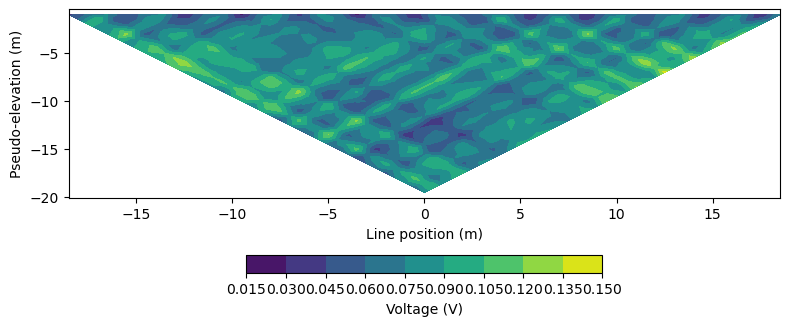

In [13]:
# Plot apparent chargeability
fig, ax1 = plt.subplots(1, 1, figsize=(8,6))
ax = dc_utils.plot_pseudosection(
    ip_survey,
    d_obs,
    data_type='potential',
    plot_type="contourf",
    ax=ax1,
    data_location=True,
    cbar_label="Voltage (V)",
    create_colorbar=False,
)

ax[0].set_aspect(0.5)
fig.colorbar(ax[1], orientation='horizontal', shrink=0.5, pad=0.1, label='Voltage (V)')
plt.tight_layout()

plt.savefig('toy_data_noise.png', dpi=300, bbox_inches='tight')
plt.show()

### Create grid for inversion

In [14]:
##
# Define grid for inversion
dh_inv = 0.5  # base cell width
dom_width_x = 100.0  # domain width x
dom_width_z = 30.0  # domain width z
nbcx_inv = 2 ** int(np.round(np.log(dom_width_x / dh_inv) / np.log(2.0)))  # num. base cells x
nbcz_inv = 2 ** int(np.round(np.log(dom_width_z / dh_inv) / np.log(2.0)))  # num. base cells z

# Define the base mesh
hx_inv = [(dh_inv, nbcx_inv)]
hz_inv = [(dh_inv, nbcz_inv)]
mesh_inv = TreeMesh([hx_inv, hz_inv], x0="CN")

# Refine core mesh region
mesh_inv.refine_box([-30, -12], [30, 0.0], -1, finalize=False)
mesh_inv.finalize()

C:\Users\dwill\AppData\Local\Temp\ipykernel_14696\121590098.py:12: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  mesh_inv = TreeMesh([hx_inv, hz_inv], x0="CN")


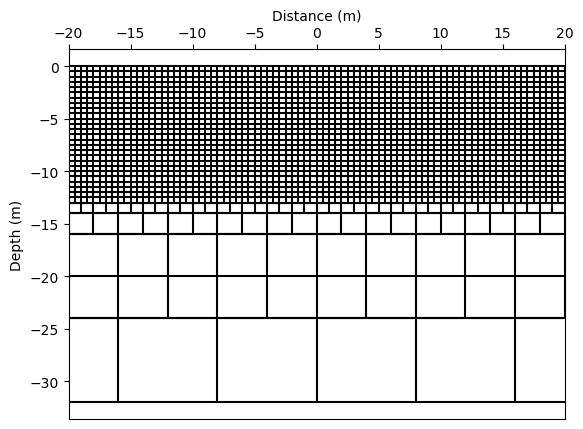

In [15]:
ax = mesh_inv.plot_grid(color='black')
plt.grid(False)
ax.set_xlim([-20,20])
ax.set_xlabel('Distance (m)', loc='center')
ax.set_ylabel('Depth (m)')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.savefig('toy_grid_inv.png', dpi=300)

In [16]:
# Define conductivity model in S/m 
air_conductivity = 1e-8
background_conductivity = 1e-2

# Find active cells in forward modeling (cell below surface)
ind_active_inv = active_from_xyz(mesh_inv, topo_xyz[:, [0, 2]])

# Define mapping from model to active cells
nC = int(ind_active_inv.sum())
conductivity_map_inv = maps.InjectActiveCells(mesh_inv, ind_active_inv, air_conductivity)

# Define model
conductivity_model_inv = background_conductivity * np.ones(nC)

chargeability_map_inv = maps.InjectActiveCells(mesh_inv, ind_active_inv, air_chargeability)

ip_simulation_inv = ip.Simulation2DNodal(mesh_inv,
    survey=ip_survey,
    etaMap=chargeability_map_inv,
    sigma=conductivity_map_inv * conductivity_model_inv,
    solver=Solver,
    storeJ=True,
) 

In [17]:
background_chargeability = 1e-2
starting_chargeability_model = background_chargeability * np.ones(nC)

ip_data_misfit = data_misfit.L2DataMisfit(data=data_obj, simulation=ip_simulation_inv)

# Define the regularization (model objective function)
ip_regularization = regularization.WeightedLeastSquares(
    mesh_inv,
    active_cells=ind_active_inv,
    mapping=maps.IdentityMap(nP=nC),
    alpha_s=0.01,
    alpha_x=1,
    alpha_y=1,
)

# Define how the optimization problem is solved. Here it is a projected
# Gauss Newton with Conjugate Gradient solver.
ip_optimization = optimization.ProjectedGNCG(
    maxIter=15, lower=0.0, upper=1000.0, maxIterCG=30, tolCG=1e-2
)

# Here we define the inverse problem that is to be solved
ip_inverse_problem = inverse_problem.BaseInvProblem(
    ip_data_misfit, ip_regularization, ip_optimization
)

update_sensitivity_weighting = directives.UpdateSensitivityWeights(threshold_value=1e-3)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)
beta_schedule = directives.BetaSchedule(coolingFactor=2, coolingRate=1)
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)
target_misfit = directives.TargetMisfit(chifact=1.0)
update_jacobi = directives.UpdatePreconditioner()

directives_list = [
    update_sensitivity_weighting,
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
    update_jacobi,
]

# Here we combine the inverse problem and the set of directives
ip_inversion = inversion.BaseInversion(
    ip_inverse_problem, directiveList=directives_list
)

# Run inversion
eta_est = ip_inversion.run(starting_chargeability_model)


Running inversion with SimPEG v0.23.1.dev10+gf697d2455
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        


C:\Users\dwill\.conda\envs\simpeg-dev\Lib\site-packages\pymatsolver\solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.94e+06  2.22e+05  0.00e+00  2.22e+05    4.25e+04      0              
   1  1.47e+06  1.25e+04  2.04e-03  1.55e+04    1.19e+04      0              
   2  7.35e+05  9.40e+03  3.51e-03  1.20e+04    9.73e+03      0   Skip BFGS  
   3  3.68e+05  6.68e+03  6.17e-03  8.94e+03    8.66e+03      0   Skip BFGS  
   4  1.84e+05  4.58e+03  1.01e-02  6.44e+03    7.84e+03      0   Skip BFGS  
   5  9.19e+04  3.25e+03  1.53e-02  4.66e+03    7.11e+03      0   Skip BFGS  
   6  4.59e+04  2.34e+03  2.21e-02  3.36e+03    5.97e+03      0   Skip BFGS  
   7  2.30e+04  1.88e+03  3.20e-02  2.61e+03    6.97e+03      0   Skip BFGS  
   8  1.15e+04  1.24e+03  4.62e-02  1.77e+03    3.30e+03      0              
   9  5.74e+03  9.57e+02

In [18]:
d_pred = ip_simulation_inv.dpred(eta_est)
chisq = np.sum((d_obs - d_pred)**2/d_err**2)
N = np.size(d_pred)
chisq = chisq/N
print(chisq)

0.8619603563723333


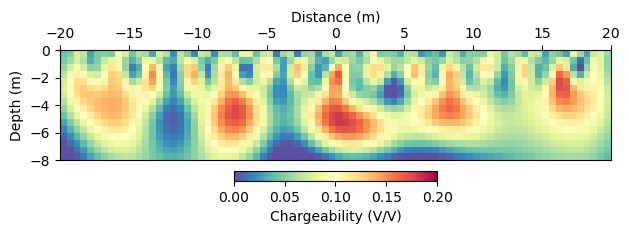

In [21]:
fig, ax = plt.subplots()
eta = eta_est
out = mesh_inv.plot_image(eta, normal="Y",
                          ax=ax, clim = (0,0.2),
                          grid=False, pcolor_opts={"cmap": "Spectral_r"})
cb = plt.colorbar(out[0], fraction=0.025, 
                  orientation='horizontal', 
                  ax=ax, pad=0.025)
cb.set_label("Chargeability (V/V)")

ax.set_xlim(-20, 20)
ax.set_ylim(-8, 0)
ax.set_yticks([0, -2, -4, -6, -8])
ax.set_aspect(1.0)
ax.set_xlabel('Distance (m)', loc = "center")
ax.set_ylabel('Depth (m)')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.savefig('ip-synth_sol_simpeg.png', dpi=300, bbox_inches='tight')

NameError: name 'merr_2' is not defined

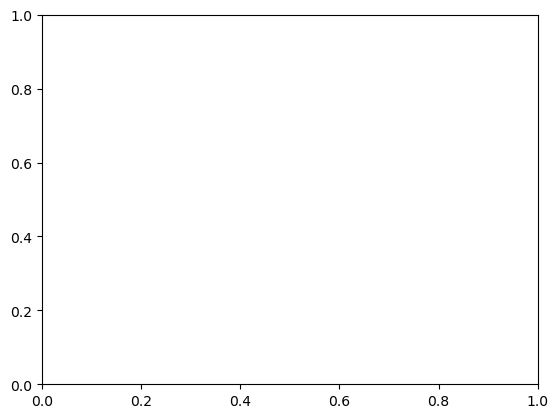

In [22]:
fig, ax = plt.subplots()
eta = merr_2
out = mesh_inv.plot_image(eta, normal="Y",
                          ax=ax,
                          grid=False, pcolor_opts={"cmap": "Spectral_r"})
cb = plt.colorbar(out[0], fraction=0.025, 
                  orientation='horizontal', 
                  ax=ax, pad=0.025)
cb.set_label("Estimated error (V/V)")

ax.set_xlim(-20, 20)
ax.set_ylim(-8, 0)
ax.set_yticks([0, -2, -4, -6, -8])
ax.set_aspect(1.0)
ax.set_xlabel('Distance (m)', loc = "center")
ax.set_ylabel('Depth (m)')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.savefig('ip-synth_err.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, 1)
eta = mk
out = mesh_inv.plot_image(eta, normal="Y",
                          ax=ax, clim = (0,0.2),
                          grid=False, pcolor_opts={"cmap": "Spectral_r"})
cb = plt.colorbar(out[0], fraction=0.025, 
                  orientation='horizontal', 
                  ax=ax, pad=0.025)
cb.set_label(r"Trade-off parameter $\eta$ (m)")

ax.set_xlim(-20, 20)
ax.set_ylim(-8, 0)
ax.set_aspect(1.0)
ax.set_xlabel('Distance (m)', loc = "center")
ax.set_ylabel('Depth (m)')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.savefig('fig02.png')

In [ ]:
np.save('mk.npy', mk)
np.save('mk_err.npy', merr)

In [ ]:
nx = np.size(xv)
nz = np.size(zv)

m_plot = np.reshape(mk, (nx, nz))
m_plot = m_plot.T
fig, ax = plt.subplots()
ax.imshow(m_plot)

In [ ]:
mk_plot = mk.copy()
mk_plot[np.where(mk == 0)] = np.NaN
fig, ax = plt.subplots(1, 1)
eta = chargeability_map*mk_plot
eta[~ind_active] = np.NaN
out = mesh.plot_image(eta, normal="Y",
                      ax=ax, clim = (0,0.21),
                      grid=False, pcolor_opts={"cmap": mpl.cm.jet})
cb = plt.colorbar(out[0], fraction=0.025, 
                  orientation='horizontal', 
                  ax=ax, pad=0.025)
cb.set_label("Chargeability (V/V)")

#ax.set_title("SOLA solution")
ax.set_xlim(-40, 40)
ax.set_ylim(-10, 0)
ax.set_aspect(2.0)
ax.set_xlabel('Distance (m)', loc = "center")
ax.set_ylabel('Depth (m)')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.set_aspect(1)
plt.tight_layout()
plt.savefig('toy_sola_full.png', dpi=600, bbox_inches='tight')